# Imports

In [8]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
from keras.models import load_model, Model
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2

import random
def fix_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
fix_seeds(1)

# Functions

In [9]:
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
# Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    
# Making sure dimensionless bond length is less than 1
def bond(bl):
    bln = -bl*(bl<0)
    blp = bl*(bl>=1.0) - 1*(bl>=1.0)
    return bln+blp

# # Making sure final porosity is less than initial
# def poros(poroi, porof):
# #     porof[porof < 0] = 1-porof[porof < 0]
#     porof[porof < 0] = poroi[0]-porof[porof < 0]
#     print(porof)
#     return porof-poroi

# Making sure final porosity is less than initial
def poros(poroi, porof):
    porofn = -porof*(porof<0)
    porofp = porof*(porof>=poroi) - poroi*(porof>=poroi)
    return porofp+porofn

def strength1(bl, porof, nlayer=6):
    sigma01, sigma02 = 6, 31
    C1s = 21
    sigma_long = sigma01*(np.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
    sigma_long_sorted = np.sort(sigma_long, axis=-1)  # sorts along first axis (down)
    ind = np.argsort(sigma_long, axis=-1)  # sorts along first axis (down)
    bl_sorted = np.take_along_axis(bl, ind, axis=-1)  # same as np.sort(x, axis=0)
    corr_bl_sorted = np.sort(bl, axis=-1)  # sorts along first axis (down)
    return corr_bl_sorted-bl_sorted

def strength2(bl, porof, nlayer=6):
    sigma01, sigma02 = 6, 31
    C1s = 21
    sigma_long = sigma01*(np.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
    sigma_long_sorted = np.sort(sigma_long, axis=-1)  # sorts along first axis (down)
    ind = np.argsort(sigma_long, axis=-1)  # sorts along first axis (down)
    bl_sorted = np.take_along_axis(bl, ind, axis=-1)  # same as np.sort(x, axis=0)
    return sum(bl_sorted[1:]-bl_sorted[:-1]<0)/14

def phy_loss_mean(params):
    # useful for cross-checking training
    loss1, loss2, loss3, loss4, lam1, lam2 = params
    x1, x2, x3 = loss1*(loss1>0), loss2*(loss2>0), loss3*(loss3>0)
    
    if x1.any() and x1.shape[0]>1:
        X_scaled1 = (x1 - np.min(x1)) / (np.max(x1) - np.min(x1))
        x1 = X_scaled1
    if x2.any() and x2.shape[0]>1:
        X_scaled2 = (x2 - np.min(x2)) / (np.max(x2) - np.min(x2))
        x2 = X_scaled2
    if x3.any() and x3.shape[0]>1:
        X_scaled3 = (x3 - np.min(x3)) / (np.max(x3) - np.min(x3))
        x3 = X_scaled3
    return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3))



def PIML(optimizer_name, optimizer_val, pre_train, tr_size, lamda, iteration, n_nodes, n_layers, drop_frac, reg, samp):
        
    fix_seeds(1)
    
    # Hyper-parameters of the training process
    batch_size = 2
#     num_epochs = 600
    num_epochs = 200
    val_frac = 0.2
    patience_val = 150
    
    # Initializing results filename
    exp_name = "DNN_pre_" + pre_train + optimizer_name + '_trsize' + str(tr_size) + '_iter' + str(iteration)
    exp_name = exp_name.replace('.','pt')
    results_dir = '../results_BK_v2_cnstTest/'
    model_name = results_dir + exp_name + '_model.h5' # storing the trained model
    
    if reg==True and samp==25:
        results_name = results_dir + exp_name + '_results_25_regularizer.dat' # storing the results of the model
    elif reg==False and samp==25:
        results_name = results_dir + exp_name + '_results_25.dat' # storing the results of the model
    elif reg==True and samp==1519:
        results_name = results_dir + exp_name + '_results_1519_regularizer.dat' # storing the results of the model
    elif reg==False and samp==1519:
        results_name = results_dir + exp_name + '_results_1519.dat' # storing the results of the model
    
    # Load labeled data
    data1 = np.loadtxt('../data/labeled_data.dat').astype(np.float32)
    x_labeled = data1[:, :-5]
    y_labeled = data1[:, -3:-1] # dimensionless bond length and porosity measurements
    if samp==25:
        data2 = np.loadtxt('../data/unlabeled_data_BK_constw_v2_25.dat')
        x_unlabeled = data2[:, :]
    elif samp==1519:
        data2 = np.loadtxt('../data/unlabeled_data_BK_constw_v2_1525.dat')
        x_unlabeled = data2[:, :]
    x_unlabeled1 = x_unlabeled[:1303, :]
    x_unlabeled2 = x_unlabeled[-6:, :]
    x_unlabeled = np.vstack((x_unlabeled1,x_unlabeled2))

    # normalize dataset with MinMaxScaler
    scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
    x_labeled = scaler.fit_transform(x_labeled)
    x_unlabeled[:,:-3] = scaler.fit_transform(x_unlabeled[:,:-3])
    
    
    # initial porosity & physics outputs are removed
    x_unlabeled = x_unlabeled[:, :-3]
    
    # train and test data
    trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]
    testX, testY = x_labeled[20:,:], y_labeled[20:]
    
    dependencies = {
     'root_mean_squared_error': root_mean_squared_error
        }

    # load the pre-trained model using non-calibrated physics-based model predictions (./data/unlabeled.dat)
    loaded_model = load_model(results_dir + pre_train, custom_objects=dependencies)
    
    # Creating the model
    model = Sequential()
    for layer in np.arange(n_layers):
        if layer == 0:
            model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
        else:
            if reg:
                model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=.001, l2=.001)))
            else:
                model.add(Dense(n_nodes, activation='relu'))
        model.add(Dropout(rate=drop_frac))
    model.add(Dense(2, activation='linear'))
    
    # pass the weights to all layers but 1st input layer, whose dimensions are updated
    for new_layer, layer in zip(model.layers[1:], loaded_model.layers[1:]):
        new_layer.set_weights(layer.get_weights())

    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer_val,
                  metrics=[root_mean_squared_error])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val, verbose=1)
    
    print('Running...' + optimizer_name)
    history = model.fit(trainX, trainY,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        verbose=0,
                        validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])

    
    test_score = model.evaluate(testX, testY, verbose=0)
    
    # compute physical inconsistency
    predictions = model.predict(testX)
    
    init_poro = data1[20:, -1]
    phyloss1 = bond(predictions[:,0]) # physics loss 1
    phyloss2 = poros(init_poro, predictions[:,1]) # physics loss 2
    phyloss3 = strength1(predictions[:,0], predictions[:,1])
    phyloss4 = strength2(predictions[:,0], predictions[:,1])
    phyloss = phy_loss_mean([phyloss1, phyloss2, phyloss3, phyloss4, 1, 1])
    
    
    
    # save results
    results = {'train_rmse':history.history['root_mean_squared_error'], 
                                'val_rmse':history.history['val_root_mean_squared_error'],
                                'test_rmse':test_score[1], 'PhyLoss':phyloss}
               
#     save_obj(results, results_name)
    
    return results, results_name, predictions, testY, test_score[1]

In [10]:
# Main Function
if __name__ == '__main__':
    
    fix_seeds(1)
    # List of optimizers to choose from    
    optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
    optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]
    
    # selecting the optimizer
    optimizer_num = 1
    optimizer_name = optimizer_names[optimizer_num]
    optimizer_val = optimizer_vals[optimizer_num]
    
    # Selecting Other Hyper-parameters
    drop_frac = 0 # Fraction of nodes to be dropped out
    n_layers = 2 # Number of hidden layers
    n_nodes = 10 # Number of nodes per hidden layer
    
    # pre-trained model
#     pre_train = 'Pre-trainAdam_drop0pt05_nL2_nN20_trsize1000_iter0.h5'
#     pre_train = 'Pre-train_wPhyLoss_Adam_drop0pt05_nL2_nN20_trsize1000_lamda[1, 1]_iter0.h5'
#     pre_train = 'Pre-trainAdam_drop0_nL2_nN20_trsize1400_iter0.h5'
#     pre_train = 'Pre-trainAdam_drop0_nL2_nN20_trsize1500_iter0.h5'
    
    # 25 synthetic data
#     pre_train = 'Pre-trainAdam_drop0_nL2_nN10_trsize24_iter0.h5'
    
    # 1519 synthetic data
#     pre_train = 'Pre-trainAdam_drop0_nL2_nN10_trsize1303_iter0.h5'
    # 1519 synthetic data
#     pre_train = 'Pre-trainAdam_drop0_nL2_nN10_trsize1515_iter0.h5'
    
#     pre_train = 'Pre-trainAdadelta_drop0pt2_nL2_nN10_trsize1515_iter0.h5'
    
#     pre_train = 'Pre-trainAdadelta_drop0_nL2_nN10_trsize1250_iter0.h5'
    
#     pre_train = 'Pre-trainAdadelta_drop0_nL2_nN10_trsize1300_iter0.h5'
#     pre_train = 'Pre-trainAdadelta_drop0_nL2_nN10_trsize1200_iter0.h5'
    pre_train = 'Pre-trainAdadelta_drop0_nL2_nN10_trsize1308_iter0.h5'
    
    
#     pre_train = 'Pre-trainAdadelta_drop0_nL2_nN10_trsize1305_iter0.h5'
    
    #set lamda=0 for pgnn0
#     lamda = [.01, .01, .01, 0] # Physics-based regularization constant
#     lamda = [.05, .05, .05, 0] # Physics-based regularization constant
    lamda = [0.3, 0.15, 0.008, 0] # Physics-based regularization constant 
#     lamda = [.001, .001, .001, 0] # Physics-based regularization constant
#     lamda = [0, 0, 0, 0] # Physics-based regularization constant
#     lamda = [1.75, 1, 0.15, 0]
    
    # Iterating over different training fractions and splitting indices for train-test splits
    trsize_range = [4,6,8,10,20]
    
    #default training size = 5000
    tr_size = trsize_range[-1]
    
    # use regularizer
    reg = True
    
    # sample size used
    samp = 1519
#     samp = 25
    
    # total number of runs
    iter_range = np.arange(1)
    testrmse = []
    # iterating through all possible params
    for iteration in iter_range:
        results, result_file, pred, obs, rmse = PIML(optimizer_name, optimizer_val, 
                                               pre_train, tr_size, lamda, iteration, n_nodes, n_layers, drop_frac, reg, samp)
        testrmse.append(rmse)

Running...Adadelta
iter: 0 nL: 2 nN: 10 trsize: 20 TestRMSE: 0.02300146408379078 PhyLoss: 0.16286933422088623 



In [43]:
# from statistics import stdev
# print(sum(testrmse) / len(testrmse),stdev(testrmse))

In [44]:
pred

array([[0.75909126, 0.01983111],
       [0.75909126, 0.01983111],
       [0.57942873, 0.04714052],
       [0.6532545 , 0.03683592],
       [0.78207874, 0.01489861],
       [0.7276804 , 0.01755858],
       [0.72707176, 0.01790913],
       [0.6532545 , 0.03683592],
       [0.6716534 , 0.02889196],
       [0.75374657, 0.01607068],
       [0.78207874, 0.01489861],
       [0.6394112 , 0.0371033 ],
       [0.6953948 , 0.0307659 ],
       [0.6588772 , 0.04099031],
       [0.7476872 , 0.01682325],
       [0.7276804 , 0.01755858],
       [0.732643  , 0.01786154],
       [0.75909126, 0.01983111],
       [0.70622945, 0.03150725]], dtype=float32)

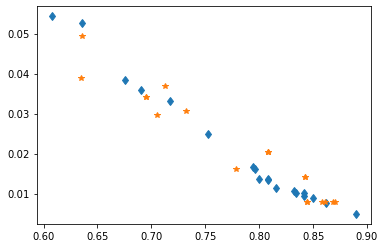

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(obs[:,0], obs[:,1], 'd')
plt.plot(pred[:,0], pred[:,1], '*')
# plt.title('Model accuracy')
# plt.ylabel('RMSE')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [5]:
save_obj(pred, "../results_BK_v2_cnstTest/pred_upd.dat")

In [8]:
# import pickle
# # import glob
# # print(glob.glob("../results/*.dat"))

# def save_obj(obj, name ):
#     with open(name, 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# save_obj(results, result_file)

# # def load_obj(name):
# #     with open(name, 'rb') as f:
# #         return pickle.load(f)

# # results = load_obj(result_file)

In [11]:
dict_keys = []

# get key and value 
print ("Dict keys are: ") 
for key, value in results.items(): 
    dict_keys.append(key)

print(dict_keys)
# train_loss_Phy = results[dict_keys[0]]
# val_loss_Phy = results[dict_keys[1]]
train_rmse = results[dict_keys[0]]
val_rmse = results[dict_keys[1]]
test_rmse = results[dict_keys[2]]
PhyLoss = results[dict_keys[3]]
print("Test RMSE: ",test_rmse,"PhyLoss: ", PhyLoss)

Dict keys are: 
['train_rmse', 'val_rmse', 'test_rmse', 'PhyLoss']
Test RMSE:  0.02300146408379078 PhyLoss:  0.16286933422088623


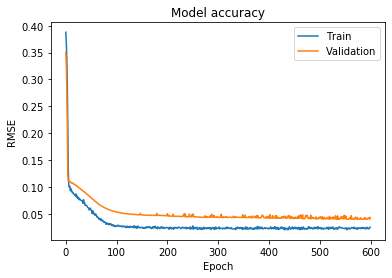

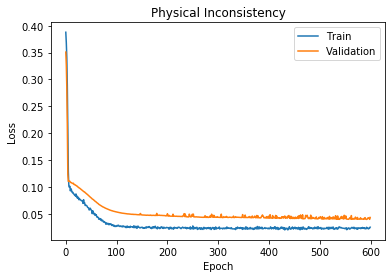

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(train_rmse)
plt.plot(val_rmse)
plt.title('Model accuracy')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(train_loss_Phy)
plt.plot(val_loss_Phy)
plt.title('Physical Inconsistency')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [12]:
import matplotlib.pyplot as plt
import matplotlib
import os

# Adjust your matplotlib script by adding the following lines after import matplotlib
matplotlib.use("pdf")
# matplotlib.use("pgf")

    
matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
# add LaTeX on python path
user_name = os.getlogin()
os.environ["PATH"] += os.pathsep + 'C:/Users/' + user_name + '/AppData/Local/Programs/MiKTeX 2.9/miktex/bin/x64'

#===========================     Using LaTeX compatible fonts      =============================== #
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')    
    
# get the figure
fig = plt.figure()

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
# plt.plot(exp[:,0],exp[:,1], 'x', color=colors[1], markersize=7)
plt.plot(train_rmse,  "-", color=colors[0])
plt.plot(val_rmse,  "--", color=colors[1])
plt.ylabel('RMSE', fontsize=22)
plt.xlabel('Epoch', fontsize=22)
plt.ylim(0.0,0.5)
plt.legend(['Train', 'Validation'], loc='best', fontsize=12)
plt.tick_params(labelsize=20)
plt.xticks(np.arange(0, len(train_rmse)+1, 50.0))
plt.show()


filename = '../figs/epoch_dnn_upd'

# save as PDF
fig.savefig("{}.pdf".format(filename), bbox_inches='tight', dpi=300)

C:\Users\berkc\Miniconda3\envs\Clone_Research_AM_2020\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
